Secure Data Vault (SDV)
==========

This notebook is used to test drive [**SDV**](https://docs.sdv.dev/sdv), an open source library from MIT for generating synthetic data.

Data Set
------------------

[Lending Club loan data set](https://www.kaggle.com/wordsforthewise/lending-club).  I like this data set due to its size and high dimensionality.  The data inside is also pretty raw with many columns containing null values which provides us an opportunity to do some data prep/cleansing - just like in any real-world situation.

Many of SDV's models are computationally intensive and will overwhelm most general-purpose VM instances (e.g. Azure's Dv4-series).  I've created a utility called [randomSampler.py](./randomSampler.py) to help reduce the data set to a more manageable size for your personal equipment.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Load and prep data set

In [2]:
original_df = pd.read_csv('data/1000_accepted_samples.csv', low_memory=False)
original_df.shape

(1000, 151)

Create a copy of the original dataframe.  We'll play with the copy to avoid having to reload the original dataset from disk later.


In [3]:
df = original_df.copy(deep=True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68072182,NaN,22900.0,22900.0,22900.0,60 months,16.59,564.09,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,67838439,NaN,35000.0,35000.0,35000.0,36 months,12.59,1172.39,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,67988290,NaN,30000.0,30000.0,30000.0,36 months,13.67,1020.53,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,67735877,NaN,6000.0,6000.0,6000.0,36 months,11.99,199.26,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,67735862,NaN,16450.0,16450.0,16300.0,60 months,24.99,482.74,F,F4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Description for some of the columns can be found at https://www.rubydoc.info/gems/lending_club/0.0.2/LendingClub/Loan.

### Determine if there are opportunities to reduce dimensionality
Let's first see if there are any columns with missing values.

In [5]:
# Find the count and percentage of missing values
df_columns_na = pd.DataFrame({
    '% Empty': 100*df.isnull().sum()/len(df), 
    'Count': df.isnull().sum()
    })

# Determine columns with null count > 0
df_columns_na_sorted = df_columns_na[df_columns_na['Count'] > 0].sort_values('% Empty', ascending=False)
df_columns_na_sorted

,% Empty,Count
member_id,100.0,1000
orig_projected_additional_accrued_interest,99.8,998
hardship_dpd,99.7,997
hardship_reason,99.7,997
hardship_status,99.7,997
...,...,...
total_bal_ex_mort,2.5,25
title,1.2,12
revol_util,0.2,2
last_pymnt_d,0.1,1


In [6]:
df_columns_na_sorted.head()
print("Data set has " + str(df.shape[1]) + " columns.\n" +
    "Of which, " + str(df_columns_na_sorted.shape[0]) + " have missing values.")

Data set has 151 columns.
Of which, 98 have missing values.


In [7]:
# Drop columns with a certain threshold of missing values
threshold = 75 # % threshold
df.dropna(axis='columns', thresh=int(threshold/100*len(df)), inplace=True)
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68072182,22900.0,22900.0,22900.0,60 months,16.59,564.09,D,D2,Director Accounting Policy,...,75.0,0.0,0.0,69800.0,56778.0,33600.0,35000.0,N,Cash,N
1,67838439,35000.0,35000.0,35000.0,36 months,12.59,1172.39,C,C2,Clinical Manager,...,28.6,0.0,0.0,444838.0,102508.0,56600.0,63930.0,N,Cash,N
2,67988290,30000.0,30000.0,30000.0,36 months,13.67,1020.53,C,C4,Informatica,...,100.0,0.0,0.0,264678.0,51569.0,9000.0,47620.0,N,Cash,N
3,67735877,6000.0,6000.0,6000.0,36 months,11.99,199.26,C,C1,Head of Human Resources,...,0.0,0.0,0.0,245839.0,40179.0,8500.0,36826.0,N,Cash,N
4,67735862,16450.0,16450.0,16300.0,60 months,24.99,482.74,F,F4,driver / video photo,...,100.0,0.0,0.0,64735.0,52838.0,4800.0,59635.0,N,Cash,N


### Distribution of data types

Text(0, 0.5, 'Data type')

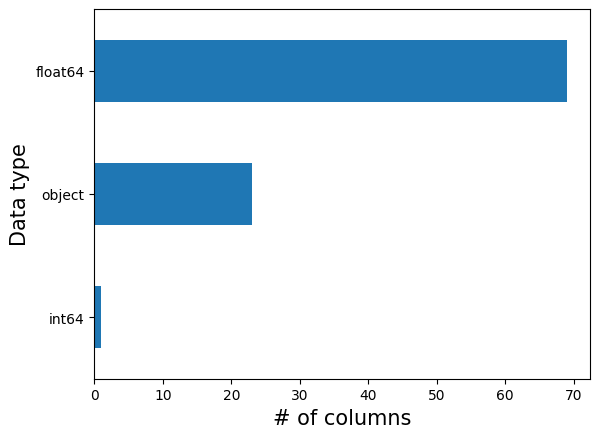

In [8]:
# Number of each type of column
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.xlabel('# of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

In [9]:
# Check amount of categorical data for columns with object datatype
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                       2
grade                      7
sub_grade                 35
emp_title                751
emp_length                11
home_ownership             3
verification_status        3
issue_d                  102
loan_status                8
pymnt_plan                 1
url                     1000
purpose                   13
title                     99
zip_code                 423
addr_state                48
earliest_cr_line         348
initial_list_status        2
last_pymnt_d              80
last_credit_pull_d        56
application_type           2
hardship_flag              1
disbursement_method        2
debt_settlement_flag       2
dtype: int64

In [10]:
# Inspect a few columns

df['purpose'].unique()
#df['grade'].unique()
#df['sub_grade'].unique()
#df['last_credit_pull_d'].unique()
#df['term'].unique()

array(['credit_card', 'debt_consolidation', 'home_improvement', 'medical',
       'house', 'small_business', 'other', 'major_purchase', 'car',
       'moving', 'vacation', 'renewable_energy', 'wedding'], dtype=object)

In [11]:
# Recode emp_length column: fill empty fields with 0, remove any text, 10+ yrs gets coded as 10.
df['emp_length'].fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', regex=True, inplace=True)

df['emp_length'].unique()

array(['3', '10', '1', '5', 0, '8', '4', '9', '2', '7', '6'], dtype=object)

Text(0, 0.5, '# of loans')

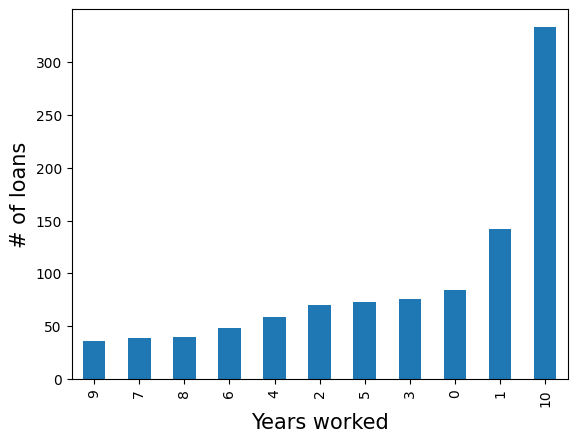

In [12]:
# plot length of employment against number of loans
df['emp_length'].value_counts().sort_values().plot(kind='bar')
plt.xlabel('Years worked',fontsize=15)
plt.ylabel('# of loans',fontsize=15)

In [13]:
# Remove string characters in 'term' column
df['term'] = df['term'].map(lambda x: x.lstrip(' ').rstrip('months'))

df['term'].unique()

array(['60 ', '36 '], dtype=object)

In [14]:
# Remove string characters in 'zipcode' column
df['zip_code'] = df['zip_code'].str.replace(r'\D', '')

/var/folders/k_/ljqnpgh17lj6lhcnbyz0g_fh0000gp/T/ipykernel_37594/3180410483.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['zip_code'] = df['zip_code'].str.replace(r'\D', '')


In [15]:
# Change datatypes to INTs in the following columns
df.term = df.term.astype("int64") 
df.emp_length = df.emp_length.astype("int64") 
#df.zip_code = df.zip_code.astype("int64")

In [16]:
# Drop unnecessary column(s) and assign to new dataframe that represents our authentic dataset
authentic_df = df.drop(['url'], axis=1)
authentic_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68072182,22900.0,22900.0,22900.0,60,16.59,564.09,D,D2,Director Accounting Policy,...,75.0,0.0,0.0,69800.0,56778.0,33600.0,35000.0,N,Cash,N
1,67838439,35000.0,35000.0,35000.0,36,12.59,1172.39,C,C2,Clinical Manager,...,28.6,0.0,0.0,444838.0,102508.0,56600.0,63930.0,N,Cash,N
2,67988290,30000.0,30000.0,30000.0,36,13.67,1020.53,C,C4,Informatica,...,100.0,0.0,0.0,264678.0,51569.0,9000.0,47620.0,N,Cash,N
3,67735877,6000.0,6000.0,6000.0,36,11.99,199.26,C,C1,Head of Human Resources,...,0.0,0.0,0.0,245839.0,40179.0,8500.0,36826.0,N,Cash,N
4,67735862,16450.0,16450.0,16300.0,60,24.99,482.74,F,F4,driver / video photo,...,100.0,0.0,0.0,64735.0,52838.0,4800.0,59635.0,N,Cash,N


## Exploratory data analysis

[Text(0, 0, '488'),
 Text(0, 0, '366'),
 Text(0, 0, '127'),
 Text(0, 0, '10'),
 Text(0, 0, '4'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

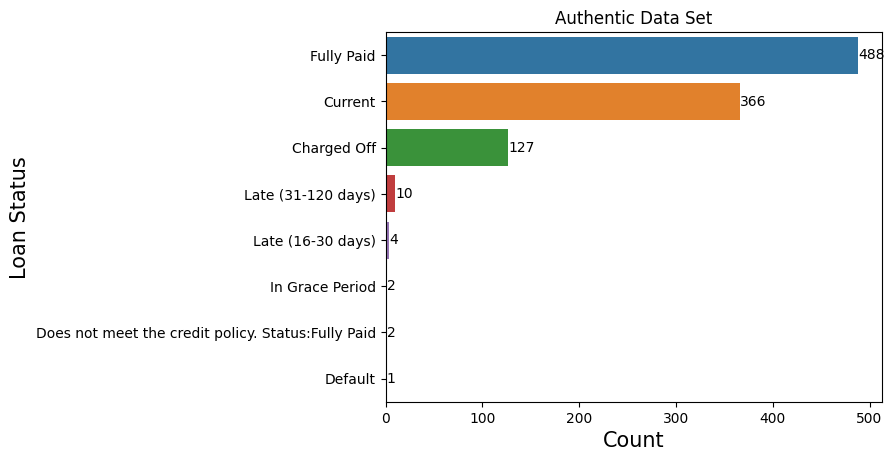

In [17]:
# Set a new variable for the purpose of displaying the value counts of 'loan_status'
loan_status_vis = authentic_df['loan_status'].value_counts()

# Plot the value counts
ax = sns.barplot(y=loan_status_vis.index, x=loan_status_vis)
plt.ylabel('Loan Status', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.title('Authentic Data Set')

# Display values in each bar
ax.bar_label(ax.containers[0])

SDV GaussianCopula
--------------------------


In [18]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

# Attempt to auto-detect metadata
metadata.detect_from_dataframe(data=authentic_df)

In [19]:
metadata.to_dict()

{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'primary_key': 'id',
 'columns': {'id': {'sdtype': 'id'},
  'loan_amnt': {'sdtype': 'numerical'},
  'funded_amnt': {'sdtype': 'numerical'},
  'funded_amnt_inv': {'sdtype': 'numerical'},
  'term': {'sdtype': 'categorical'},
  'int_rate': {'sdtype': 'numerical'},
  'installment': {'sdtype': 'numerical'},
  'grade': {'sdtype': 'categorical'},
  'sub_grade': {'sdtype': 'categorical'},
  'emp_title': {'sdtype': 'unknown', 'pii': True},
  'emp_length': {'sdtype': 'numerical'},
  'home_ownership': {'sdtype': 'categorical'},
  'annual_inc': {'sdtype': 'numerical'},
  'verification_status': {'sdtype': 'categorical'},
  'issue_d': {'sdtype': 'categorical'},
  'loan_status': {'sdtype': 'categorical'},
  'pymnt_plan': {'sdtype': 'categorical'},
  'purpose': {'sdtype': 'categorical'},
  'title': {'sdtype': 'categorical'},
  'zip_code': {'sdtype': 'unknown', 'pii': True},
  'addr_state': {'sdtype': 'categorical'},
  'dti': {'sdtype': 'numerical'},
  'del

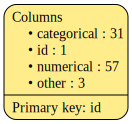

In [20]:
# Render a summarized view of the metadata.
# NOTE: This requires GraphViz to be in your system's PATH
metadata.visualize(
    show_table_details='summarized',
    output_filepath='data/output_metadata.png'
)

In [21]:
# Use the Gaussian Copula algorithm to learn our input dataset
from sdv.single_table import GaussianCopulaSynthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(authentic_df)

/Users/duc/Library/Python/3.11/lib/python/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'total_pymnt'. Data will not be rounded.
  warnings.warn(
/Users/duc/Library/Python/3.11/lib/python/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'total_rec_late_fee'. Data will not be rounded.
  warnings.warn(
/Users/duc/Library/Python/3.11/lib/python/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column 'collection_recovery_fee'. Data will not be rounded.
  warnings.warn(


In [22]:
synthesizer.save('models/gaussian_copula_learned_model.pkl')

In [23]:
loaded_model = GaussianCopulaSynthesizer.load('models/gaussian_copula_learned_model.pkl')

### Generate synthetic data from model

In [24]:
synthetic_df = synthesizer.sample(len(authentic_df))

In [25]:
synthetic_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,0,13773.0,13768.0,12481.745054,60,13.65,288.62,D,B4,sdv-pii-a0ef0,...,79.7,0.0,0.0,161031.0,NaN,33833.0,NaN,N,Cash,N
1,1,19615.0,19608.0,21044.309604,36,10.58,706.50,B,A5,sdv-pii-pe4mc,...,32.1,1.0,0.0,495342.0,126752.0,36407.0,109515.0,N,Cash,N
2,2,6545.0,6547.0,5279.067344,36,9.80,158.19,A,B5,sdv-pii-4go1q,...,0.2,0.0,0.0,33325.0,17755.0,15500.0,43644.0,N,Cash,N
3,3,24829.0,24817.0,24400.569693,60,14.41,603.90,B,A5,sdv-pii-8kgmy,...,20.5,0.0,0.0,138810.0,40028.0,28290.0,NaN,N,Cash,N
4,4,7957.0,7957.0,7109.049540,60,17.51,199.62,C,C1,NaN,...,20.5,0.0,0.0,41232.0,28351.0,95.0,52565.0,N,Cash,N


[Text(0, 0, '505'),
 Text(0, 0, '364'),
 Text(0, 0, '107'),
 Text(0, 0, '14'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '1')]

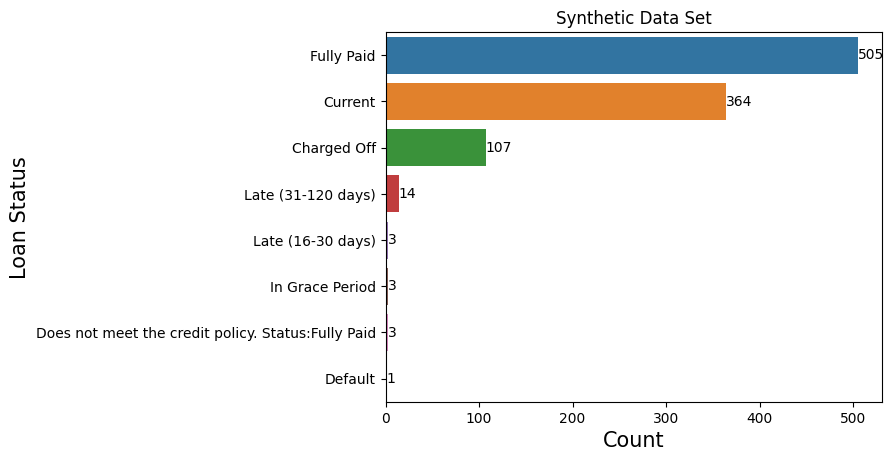

In [26]:
synthetic_loan_status_vis = synthetic_df['loan_status'].value_counts()

# Plot the value counts
ax = sns.barplot(y=synthetic_loan_status_vis.index, x=synthetic_loan_status_vis)
plt.ylabel('Loan Status', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.title('Synthetic Data Set')

ax.bar_label(ax.containers[0])

Compare the breakdown of loan statuses from the generated synthetic data set against those of the authentic data set.  There should be some congruency between the two.

In [27]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=authentic_df,
    synthetic_data=synthetic_df,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 4186/4186 [00:18<00:00, 229.58it/s]

Overall Quality Score: 88.14%

Properties:
- Column Shapes: 88.99%
- Column Pair Trends: 87.29%


In [28]:
synthetic_df.to_csv('data/output_synthetic_data_via_gaussian.csv', index=False)